Courtesy to https://github.com/deric/clustering-benchmark

In [1]:
from scipy.io import arff
import pandas as pd
import requests
import io
import urllib.request
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler

from pycvi.cluster import generate_all_clusterings
from pycvi.scores import Inertia, GapStatistic, ScoreFunction, Hartigan, Diameter, CalinskiHarabasz, Silhouette, SCORES
from pycvi.compute_scores import compute_all_scores
import warnings
warnings.filterwarnings("ignore")

/home/natacha/.cache/pypoetry/virtualenvs/clusterexp-s4OGTNKW-py3.8/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
URL_ROOT = 'https://raw.githubusercontent.com/nglm/clustering-benchmark/master/src/main/resources/datasets/'
PATH = URL_ROOT + "artificial/"
fname = URL_ROOT + "artificial.txt"

raw_text = requests.get(fname).text
all_datasets = raw_text.split("\n")
all_datasets

['mopsi-finland.arff',
 'long3.arff',
 'zelnik1.arff',
 'insect.arff',
 'disk-4500n.arff',
 'disk-4000n.arff',
 'cure-t0-2000n-2D.arff',
 'circle.arff',
 'zelnik6.arff',
 'elly-2d10c13s.arff',
 'zelnik3.arff',
 'disk-4600n.arff',
 'aggregation.arff',
 'donutcurves.arff',
 'dartboard1.arff',
 's-set3.arff',
 'disk-1000n.arff',
 'complex8.arff',
 'ds4c2sc8.arff',
 'square4.arff',
 'square5.arff',
 'dpb.arff',
 'dense-disk-3000.arff',
 'dpc.arff',
 'DS-577.arff',
 'cluto-t5-8k.arff',
 'jain.arff',
 '2dnormals.arff',
 'target.arff',
 'cluto-t4-8k.arff',
 'pmf.arff',
 'blobs.arff',
 'banana.arff',
 'sizes2.arff',
 '2d-3c-no123.arff',
 'sizes5.arff',
 'pathbased.arff',
 'cure-t2-4k.arff',
 'triangle2.arff',
 'square2.arff',
 'hypercube.arff',
 '2d-4c-no9.arff',
 'twenty.arff',
 'hepta.arff',
 'smile3.arff',
 'spherical_4_3.arff',
 'golfball.arff',
 'dense-disk-5000.arff',
 'twodiamonds.arff',
 'birch-rg3.arff',
 'donut2.arff',
 'cuboids.arff',
 'elliptical_10_2.arff',
 'sizes3.arff',
 'D31.a

In [3]:
def arff_from_github(url):
    ftpstream = urllib.request.urlopen(url)
    data, meta = arff.loadarff(io.StringIO(ftpstream.read().decode('utf-8')))
    return data, meta

def load_data_from_github(url):
    data, meta = arff_from_github(url)
    df = pd.DataFrame(data)
    # Get only data, not the labels and convert to numpy
    data = df.iloc[:, 0:-1].to_numpy()
    labels = df.iloc[:, -1].to_numpy()
    return data, labels, meta

In [4]:
unimodal = [
    "birch-rg1.arff", "birch-rg2.arff", 
    "golfball.arff", 
]
unlabeled = [
    "birch-rg3.arff", 
    "mopsi-finland.arff", "mopsi-joensuu.arff", 
    "s-set3.arff", "s-set3.arff",
    
]

In [5]:
filenames = [
    fname for fname in all_datasets 
    if (fname not in unimodal+unlabeled)]
print(len(filenames))
filenames


115


['long3.arff',
 'zelnik1.arff',
 'insect.arff',
 'disk-4500n.arff',
 'disk-4000n.arff',
 'cure-t0-2000n-2D.arff',
 'circle.arff',
 'zelnik6.arff',
 'elly-2d10c13s.arff',
 'zelnik3.arff',
 'disk-4600n.arff',
 'aggregation.arff',
 'donutcurves.arff',
 'dartboard1.arff',
 'disk-1000n.arff',
 'complex8.arff',
 'ds4c2sc8.arff',
 'square4.arff',
 'square5.arff',
 'dpb.arff',
 'dense-disk-3000.arff',
 'dpc.arff',
 'DS-577.arff',
 'cluto-t5-8k.arff',
 'jain.arff',
 '2dnormals.arff',
 'target.arff',
 'cluto-t4-8k.arff',
 'pmf.arff',
 'blobs.arff',
 'banana.arff',
 'sizes2.arff',
 '2d-3c-no123.arff',
 'sizes5.arff',
 'pathbased.arff',
 'cure-t2-4k.arff',
 'triangle2.arff',
 'square2.arff',
 'hypercube.arff',
 '2d-4c-no9.arff',
 'twenty.arff',
 'hepta.arff',
 'smile3.arff',
 'spherical_4_3.arff',
 'dense-disk-5000.arff',
 'twodiamonds.arff',
 'donut2.arff',
 'cuboids.arff',
 'elliptical_10_2.arff',
 'sizes3.arff',
 'D31.arff',
 'compound.arff',
 'long1.arff',
 'long2.arff',
 'curves2.arff',
 's-s

In [6]:
# for f in filenames:
#     url = PATH + f
#     print(url)
#     data, meta = arff_from_github(url)
#     df = pd.DataFrame(data)
#     print(df.head())

,x,y,class
0,-1.98666,-0.002289,b'0'
1,-1.95108,0.032471,b'0'
2,-1.92679,-0.046936,b'0'
3,-1.86688,-0.067810,b'0'
4,-1.84698,0.008820,b'0'
...,...,...,...
2995,3.80911,3.881070,b'8'
2996,3.83362,4.140630,b'8'
2997,3.84756,3.910280,b'8'
2998,3.89923,3.946840,b'8'


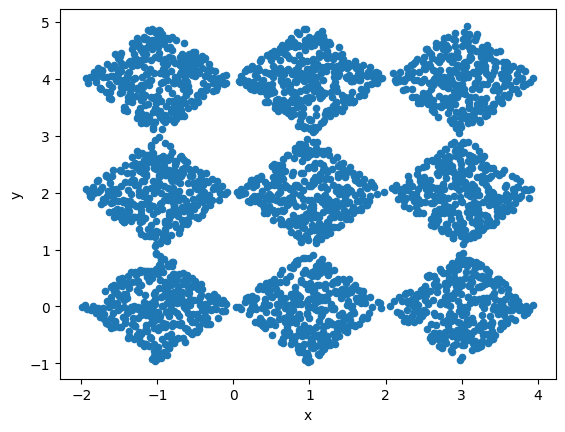

In [7]:
data, meta = arff_from_github(PATH + 'diamond9.arff')
df = pd.DataFrame(data)
df.plot.scatter("x", "y")
df

In [8]:
df_bis = df.iloc[:, 0:-1]
df_bis

,x,y
0,-1.98666,-0.002289
1,-1.95108,0.032471
2,-1.92679,-0.046936
3,-1.86688,-0.067810
4,-1.84698,0.008820
...,...,...
2995,3.80911,3.881070
2996,3.83362,4.140630
2997,3.84756,3.910280
2998,3.89923,3.946840


In [9]:
X = df_bis.to_numpy()
X

array([[-1.98666e+00, -2.28882e-03],
       [-1.95108e+00,  3.24707e-02],
       [-1.92679e+00, -4.69360e-02],
       ...,
       [ 3.84756e+00,  3.91028e+00],
       [ 3.89923e+00,  3.94684e+00],
       [ 3.93759e+00,  4.01599e+00]])

In [10]:
n_clusters_range = [i for i in range(15)]

In [11]:
l_data = []
data, labels, meta = load_data_from_github(PATH + "diamond9.arff")
l_data.append(data)
data, labels, meta = load_data_from_github(PATH + "xclara.arff")
l_data.append(data)



In [12]:
def experiment(X):
    clusterings = generate_all_clusterings(
            X,
            AgglomerativeClustering,
            n_clusters_range,
            DTW=False,
            scaler=StandardScaler(),
        )

    for s in SCORES:
        score = s()
        print(" ================ {} ================ ".format(str(score)))
        scores = compute_all_scores(
            score,
            X,
            clusterings,
            DTW=False,
            scaler=StandardScaler(),
        )
        
        for k in n_clusters_range:
            print(k, scores[0][k])
            
        k = score.select(scores)
        print("Selected k {}".format(k))

In [13]:
for i, X in enumerate(l_data):
    print(" ---------------- DATASET {} ----------------".format(i))
    experiment(X)


 ---------------- DATASET 0 ----------------
 ================ <pycvi.scores.Hartigan object at 0x7fb50487ec10> ================ 
0 0.0
1 1649.4130758435685
2 1727.3955790352336
3 1198.6319617389086
4 1081.9457880345974
5 682.7931147606222
6 846.3976966855932
7 1173.7797569526542
8 1875.6529589506397
9 132.56863222940194
10 135.65571859862106
11 140.11233520697309
12 145.71463521368705
13 152.15397542787332
14 0.0
Selected k [1]
 ================ <pycvi.scores.CalinskiHarabasz object at 0x7fb4ee6e2580> ================ 
0 -3110.954359577453
1 0.0
2 1649.4130758435638
3 2163.3108388035157
4 2418.0720236430197
5 2738.3640885195905
6 2825.9471308323446
7 3160.976911002086
8 3938.748727069956
9 5840.224585698811
10 5434.396877700605
11 5124.788766822241
12 4888.468181459337
13 4710.266881531504
14 4579.665648576012
Selected k [1]
 ================ <pycvi.scores.GapStatistic object at 0x7fb50487ec10> ================ 
0 0.0
1 0.024495401823122265
2 -0.009860736016636729
3 -0.008623664476406